# 序列模型

给定一个序列 要求我们根据已知的序列前`n`项 推出序列的下一项

时序模型中，当前数据跟之前观测到的数据有关

自回归模型使用自身过去数据预测未来

## 马尔可夫假设

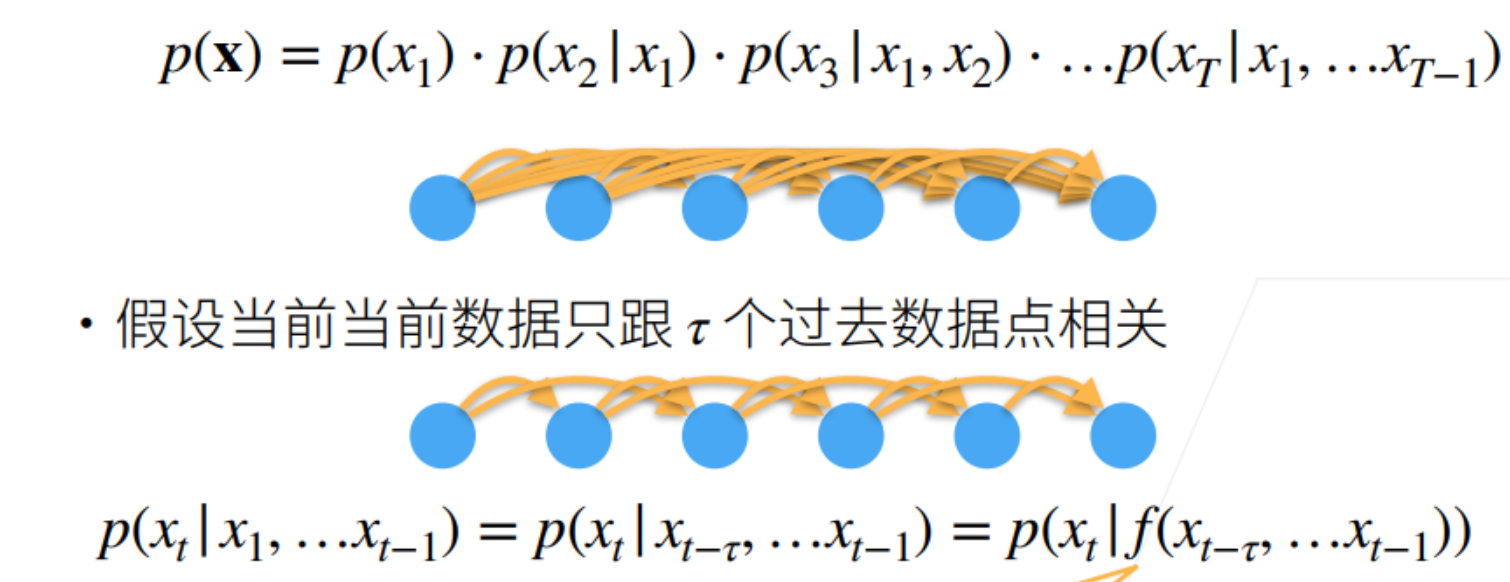

类似与`dp`的思想,我们限定序列的第`n`项只与前面的`k`项有关系,那么我们只需要每次都计算前`k`项,然后通过神经网络训练出的参数去计算第`n+1`项

马尔可夫模型假设当前只跟最近少数数据相关，从而减小模型

## 潜变量假设

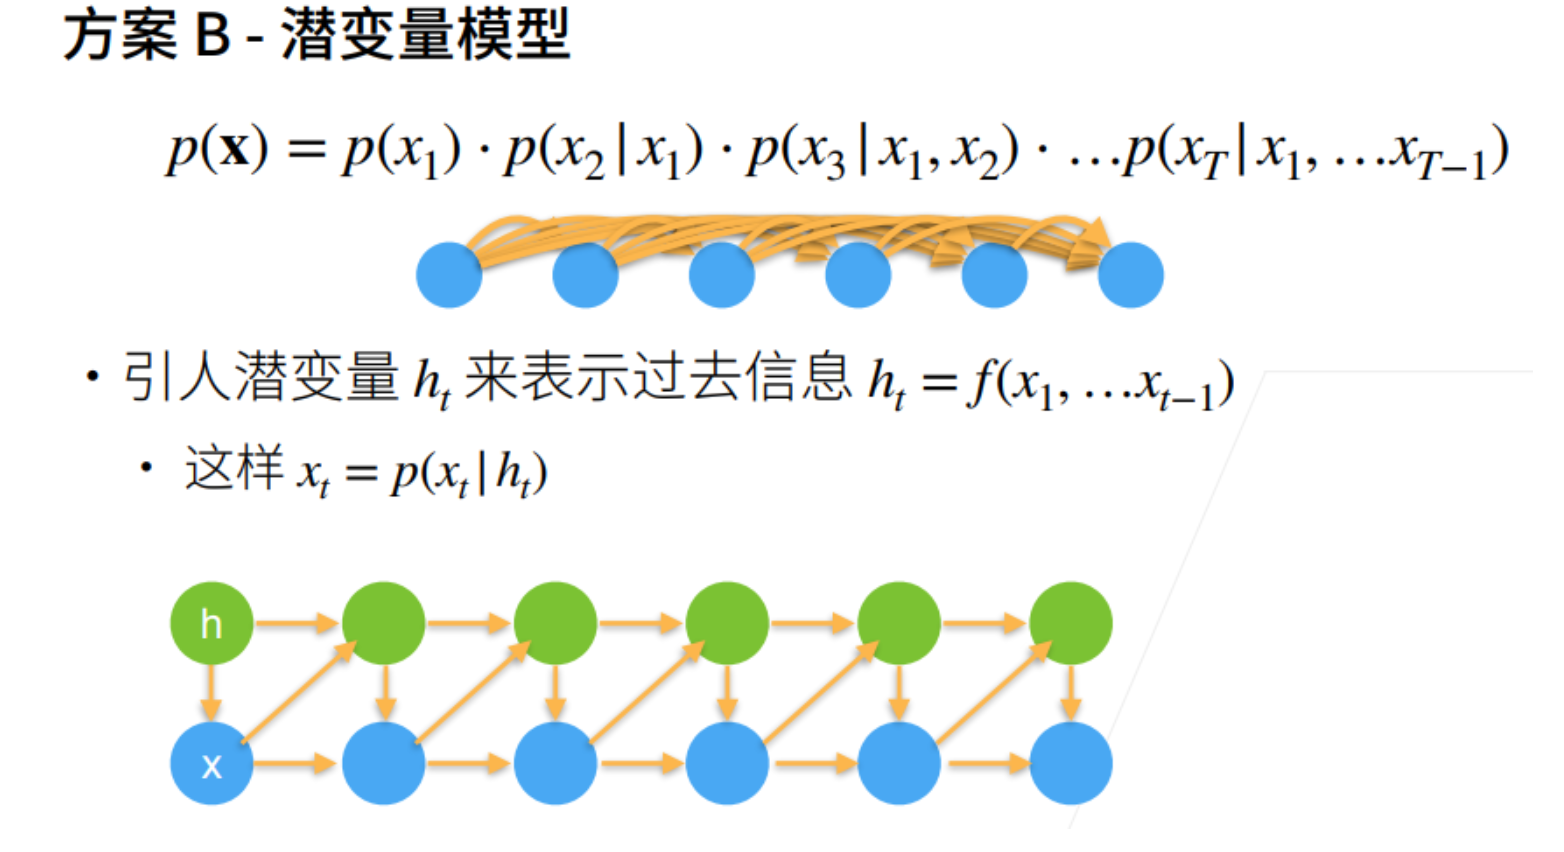

潜变量模型使用潜变量来概括历史信息

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

torch.Size([1000]) 
 1000


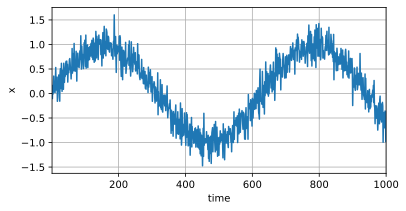

In [11]:
T=1000
time = torch.arange(1, T+1, dtype=torch.float32)
x=torch.sin(0.01*time)+torch.normal(0, 0.2, size=(T, )) #这里(T,) 表示一个一维的元组
print(x.shape, '\n', T)
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6,3))

In [27]:
def init_weight(net):
    if type(net) == nn.Linear:
        nn.init.xavier_uniform_(net.weight)
net = nn.Sequential(nn.Linear(4, 100), nn.ReLU(), nn.Linear(100, 1))
net.apply(init_weight)
loss = nn.MSELoss()

In [28]:
# 前600训练数据 后400 validation数据

tau = 4
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i : T - tau + i]
labels = x[tau:].reshape(-1, 1)
batch_size, n_train = 16, 600
# [0::4, 1::4, 2::4, 3::4] -> [4:]
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [29]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.056112
epoch 2, loss: 0.054066
epoch 3, loss: 0.056798
epoch 4, loss: 0.054383
epoch 5, loss: 0.061883


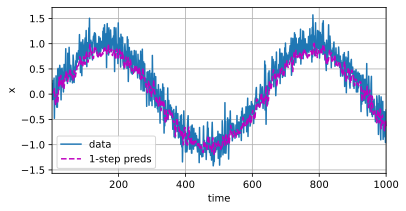

In [30]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

In [35]:
multi = torch.zeros(T)
multi[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau, T):
    multi[i] = net(multi[i-tau:i])
    

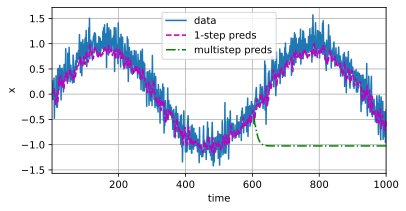

In [37]:

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multi[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

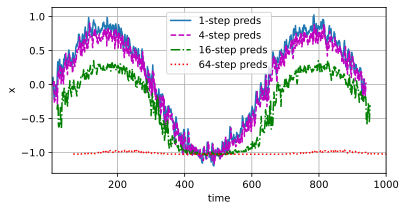

In [38]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))